# 2. 오늘의 과제: 가위바위보 분류기 만들기

전체 코드 흐름
1. 데이터 준비
2. 이미지 전처리
- 28*28 픽셀로 resize
- RGB 형식 유지 (Shape: 28*28,3)
3. 훈련/테스트 데이터 구성
- 80%(240장) 학습
- 20%(60장) 테스트
4. 모델 구성 (CNN)
- Conv2D(32 filters, 3×3, relu)
- MaxPool2D(2×2)
- Conv2D(64 filters, 3×3, relu)
- MaxPool2D(2×2)
- Flatten()
- Dense(64, relu)
- Dense(3, softmax)
- Optimizer: Adam
5. 훈련과정
- 정규화(Normalization)
- 모델학습 epoch: 20
6. test 평가
- test accuracy: 08~1.0
7. confusion Matrix 결과
- scissor 정확도 100%
- Rock 정확도 95%
- Paper 정확도 100%

In [100]:
# 라이브러리 불러오기
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.19.0
2.0.2


In [101]:
# 디렉토리 만들
!mkdir -p rock_scissor_paper/rock
!mkdir -p rock_scissor_paper/scissor
!mkdir -p rock_scissor_paper/paper


In [102]:
!ls -l /content/rock_scissor_paper

total 24
drwxr-xr-x 2 root root 4096 Dec  2 03:41 paper
drwxr-xr-x 2 root root 4096 Dec  2 03:46 paper_28
drwxr-xr-x 2 root root 4096 Dec  2 03:41 rock
drwxr-xr-x 2 root root 4096 Dec  2 03:46 rock_28
drwxr-xr-x 2 root root 4096 Dec  2 03:41 scissor
drwxr-xr-x 2 root root 4096 Dec  2 03:46 scissor_28


In [103]:
from google.colab import files
uploaded = files.upload()


Saving 보-samples.zip to 보-samples (2).zip
Saving 바위-samples.zip to 바위-samples (1).zip
Saving 가위-samples.zip to 가위-samples (1).zip


In [104]:
!ls /content


 rock_scissor_paper	'가위-samples (1).zip'	 바위-samples.zip
 sample_data		'보-samples (1).zip'	 가위-samples.zip
'바위-samples (1).zip'	'보-samples (2).zip'	 보-samples.zip


In [105]:
# !unzip "/content/바위-samples.zip" -d /content/rock_scissor_paper/rock/
# !unzip "/content/가위-samples.zip" -d /content/rock_scissor_paper/scissor/
# !unzip "/content/보-samples.zip" -d /content/rock_scissor_paper/paper/


In [106]:
import os
print(os.listdir('/content/rock_scissor_paper/rock')[:10])


['37.jpg', '23.jpg', '90.jpg', '50.jpg', '30.jpg', '72.jpg', '54.jpg', '51.jpg', '49.jpg', '52.jpg']


# 이미지 크기 확인 코드

In [107]:
from PIL import Image
import os


In [108]:
img = Image.open("/content/rock_scissor_paper/rock/37.jpg")
img_resized = img.resize((28,28))
print(img_resized.size)


(28, 28)


In [109]:
from PIL import Image
import os

base = "/content/rock_scissor_paper"

for folder in ["rock", "paper", "scissor"]:
    input_path = f"{base}/{folder}"
    output_path = f"{base}/{folder}_28"
    os.makedirs(output_path, exist_ok=True)

    for fname in os.listdir(input_path):
        if fname.lower().endswith((".jpg", ".png")):
            img = Image.open(os.path.join(input_path, fname))
            img = img.resize((28, 28))
            img.save(os.path.join(output_path, fname))

    print(folder, "완료!")


rock 완료!
paper 완료!
scissor 완료!


In [110]:
import glob


In [111]:
import os, glob
import numpy as np
from PIL import Image

def load_data(img_path, number_of_data=300):
    image_w, image_h = 28, 28

    # 28x28로 저장된 폴더를 사용
    categories = ["scissor_28", "rock_28", "paper_28"]
    #              라벨:    0          1          2

    imgs   = np.zeros((number_of_data, image_h, image_w, 3), dtype=np.int32)
    labels = np.zeros((number_of_data,), dtype=np.int32)

    idx = 0

    for label, category in enumerate(categories):
        files = glob.glob(os.path.join(img_path, category, "*.jpg"))
        print(category, "폴더에서 찾은 파일 수:", len(files))

        for file in files:
            if idx >= number_of_data:   # 최대 number_of_data까지만
                break
            img = Image.open(file)
            img = img.resize((image_w, image_h))
            img = img.convert("RGB")
            imgs[idx] = np.array(img, dtype=np.int32)
            labels[idx] = label
            idx += 1

    print("학습데이터(x_train)의 이미지 개수는", idx, "입니다.")
    return imgs[:idx], labels[:idx]


In [112]:
image_dir_path = "/content/rock_scissor_paper"
x_train, y_train = load_data(image_dir_path)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)


scissor_28 폴더에서 찾은 파일 수: 104
rock_28 폴더에서 찾은 파일 수: 102
paper_28 폴더에서 찾은 파일 수: 141
학습데이터(x_train)의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


In [113]:
# import matplotlib.pyplot as plt

# plt.imshow(x_train[0])
# print('라벨: ', y_train[0])

# 딥러닝 네트워크 설계하기

In [114]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# 가위(0), 바위(1), 보(2) 라벨이라고 가정
# x_train: (N, 28, 28, 3),  y_train: (N,)

#  모델정의
model = keras.models.Sequential()

# 입력: 28x28x3 (RGB 이미지)
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 3)))
model.add(keras.layers.MaxPool2D((2,2)))

model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPool2D((2,2)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(64, activation='relu'))


# 출력: 클래스 3개 (가위, 바위, 보)
model.add(keras.layers.Dense(3, activation='softmax'))


# MNIST와 마찬가지로 정수 라벨이므로 sparse_categorical_crossentropy 사용
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 26, 26, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,051 (476.76 KB)

 Trainable params: 122,051 (476.76 KB)

 Non-trainable params: 0 (0.00 B)

# 2. 딥러닝 네트워크 학습시키기

In [115]:
from sklearn.model_selection import train_test_split

x_train_sub, x_test, y_train_sub, y_test = train_test_split(
    x_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

print(x_train_sub.shape, y_train_sub.shape)
print(x_test.shape, y_test.shape)


(240, 28, 28, 3) (240,)
(60, 28, 28, 3) (60,)


In [116]:
x_train_sub_norm = x_train_sub / 255.0
x_test_norm      = x_test / 255.0


In [121]:
# 4. 학습
history = model.fit(
    x_train_sub_norm,
    y_train_sub,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7975 - loss: 0.5533 - val_accuracy: 0.8542 - val_loss: 0.4944
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7920 - loss: 0.5656 - val_accuracy: 0.8333 - val_loss: 0.4962
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8191 - loss: 0.5555 - val_accuracy: 0.8125 - val_loss: 0.4773
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8472 - loss: 0.4416 - val_accuracy: 0.9167 - val_loss: 0.3987
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8268 - loss: 0.4363 - val_accuracy: 0.9167 - val_loss: 0.3663
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8899 - loss: 0.4041 - val_accuracy: 0.9583 - val_loss: 0.3338
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8226 - loss: 0.4143 - val_accuracy: 0.8750 - val_loss: 0.3723
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8475 - loss: 0.4415 - val_accuracy: 0.8333 - val_loss: 0.4452


In [118]:
print("Validation accuracy:", history.history['val_accuracy'][-1])


Validation accuracy: 0.8125


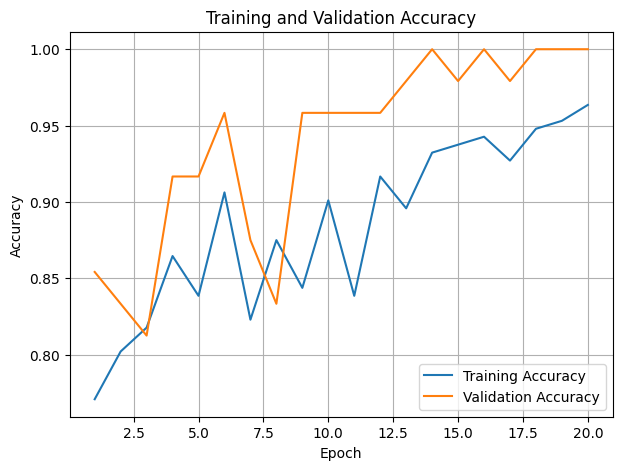

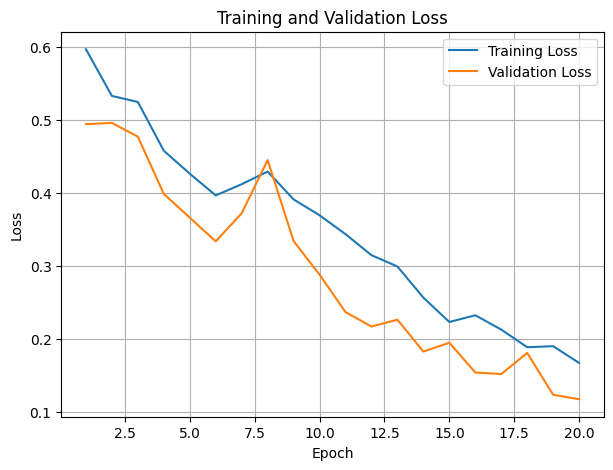

In [122]:
import matplotlib.pyplot as plt

# Epoch 숫자
epochs_range = range(1, len(history.history['accuracy']) + 1)

# 1. Accuracy 그래프
plt.figure(figsize=(7,5))
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 2. Loss 그래프
plt.figure(figsize=(7,5))
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


test 평가코드

In [120]:
test_loss, test_acc = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss:", test_loss)
print("test_acc :", test_acc)


2/2 - 0s - 27ms/step - accuracy: 0.8000 - loss: 0.5809
test_loss: 0.5808941125869751
test_acc : 0.800000011920929


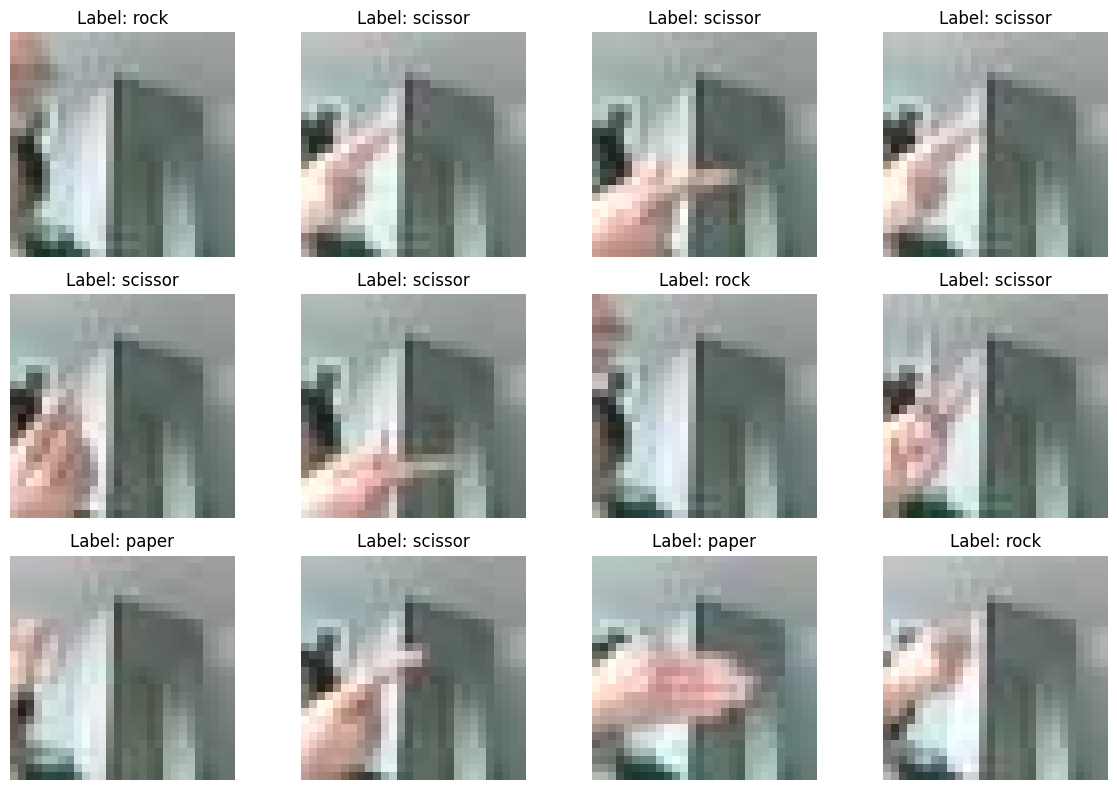

In [124]:
import matplotlib.pyplot as plt
import numpy as np

# 라벨 이름 매핑
label_name = {0: "scissor", 1: "rock", 2: "paper"}

plt.figure(figsize=(12, 8))

for i in range(12):  # test 이미지 12장 출력
    plt.subplot(3, 4, i+1)
    plt.imshow(x_test[i].astype('uint8'))   # 이미지 값이 float이면 uint8로
    plt.title(f"Label: {label_name[y_test[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


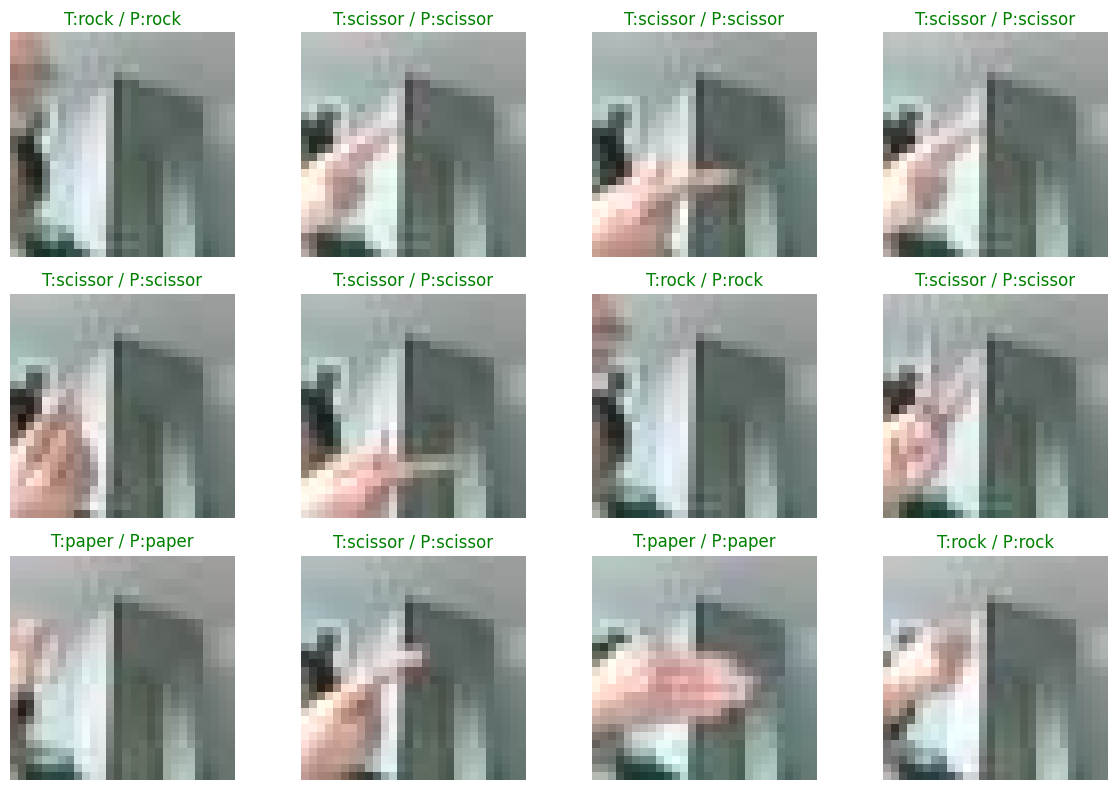

In [125]:
# 예측
pred = model.predict(x_test_norm)  # 정규화된 test 데이터로 예측
pred_labels = np.argmax(pred, axis=1)

plt.figure(figsize=(12, 8))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(x_test[i].astype('uint8'))
    true_label = label_name[y_test[i]]
    pred_label = label_name[pred_labels[i]]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"T:{true_label} / P:{pred_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


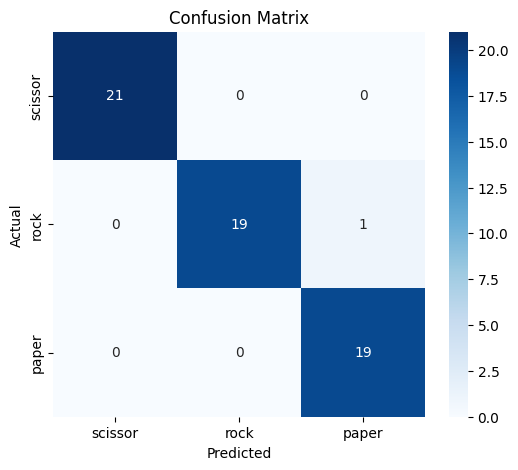

In [127]:
# 모델이 test 데이터를 예측
pred = model.predict(x_test_norm)
pred_labels = np.argmax(pred, axis=1)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred_labels)
cm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

labels = ["scissor", "rock", "paper"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



In [129]:
https://github.com/jjong-i/MODULABS_DL.git


SyntaxError: invalid syntax (ipython-input-673005605.py, line 1)

In [130]:
!git clone https://github.com/jjong-i/MODULABS_DL.git


Cloning into 'MODULABS_DL'...


In [131]:
%cd MODULABS_DL


/content/MODULABS_DL


In [132]:
!git checkout -b feature/rock-scissor-paper


Switched to a new branch 'feature/rock-scissor-paper'
